In [225]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from numpy import sqrt, sin, cos, pi, cosh, sinh, tanh, exp, linalg, log
from sympy import symbols, solve
import math
from  scipy.sparse.linalg import eigs

def principal_eigenvector (matrix):
#function returning eigenvector corresponding to the biggest eigenvalue
    N = matrix.shape[0]
    values, vectors = eigs(matrix, k = 1, which = 'LR')
    result = vectors[:, 0]
    result *= np.sqrt(N) #L2 norm of the vector should be N - ?#
    return result.reshape((N, 1))
def principal_eigenvalue(matrix):
    N = matrix.shape[0]
    values, vectors = eigs(matrix, k = 1, which = 'LR')
    return values[0]

def get_mse(truth, estimate):
#Returns mean squared error between the true vector and an estimator
    truth = truth.flatten()
    estimate = estimate.flatten()
    return min(np.mean((truth - estimate)**2), np.mean((truth + estimate)**2)) #It is impossible to learn the sign

def get_overlap(truth, estimate):
    truth = truth.flatten()
    estimate = estimate.flatten()
    return max(np.dot(truth, estimate), np.dot(truth, -estimate)) / np.linalg.norm(truth) / np.linalg.norm(estimate)

def Gibbs(qtilde,x0,z):
  p = 0.5
  h = qtilde * x0 + sqrt(qtilde) * z
  return tanh(h)/(1 + exp(qtilde/2)*(1-2*p)/(2*p * cosh(h) ))

def Gauss(z):
  return exp(-z*z/2)/sqrt(2*pi)

def ExpectGibbsRad(qtilde):
  p = 0.5
  BOUNDS = 10
  #x0 = 1  
  av_fp = lambda z: Gauss(z) * p * (Gibbs(qtilde,1,z))**2
  av_plus, err = integrate.quad(av_fp, -BOUNDS, BOUNDS)
  #x0 = -1  
  av_fm = lambda z: Gauss(z) * p * (Gibbs(qtilde,-1,z))**2
  av_minus, err = integrate.quad(av_fm, -BOUNDS, BOUNDS)
  #x0 = 0
  av_fz = lambda z: Gauss(z) * (1-2*p) * (Gibbs(qtilde,0,z))**2
  av_zero, err= integrate.quad(av_fz, -BOUNDS, BOUNDS)
  return av_plus + av_zero + av_minus

def ExpectGibbs(qtilde,prior):
  if(prior == 'gaussian'):
        return 1 - 1/(qtilde + 1)
  elif prior == 'rademacher':
        return ExpectGibbsRad(qtilde)

In [226]:
def iterate(overlaps, proportions, block_delta, prior):

  averages = [ExpectGibbs(overlap, prior) for overlap in overlaps]
  new_overlaps = [np.dot(proportions / block_delta[i], averages) for i in range(len(proportions))]  

  damping = 0.2
  new_overlaps, overlaps = np.array(new_overlaps), np.array(overlaps)

  return (1-damping) * new_overlaps + damping * overlaps, np.sqrt(np.sum((overlaps - new_overlaps)**2))
def Solve_overlaps(overlaps, proportions, block_delta, prior):
    convergence = 1000
    while (convergence > 1e-3):
        overlaps, convergence = iterate(overlaps, proportions, block_delta, prior)
        
    return overlaps

In [227]:
def predicted_curve(start, end, points, block_delta, prior):

    total_overlaps = []
    paramvec = []
    operator_normvec = []

    param_range = np.linspace(start, end, points)

    for param in param_range:
        overlaps = [1] * len(proportions)
        overlaps = Solve_overlaps(overlaps, proportions, param * block_delta, prior)
        total_overlap = 0        
        for block in range(len(proportions)):
            total_overlap += proportions[block] * ExpectGibbs(overlaps[block], prior)
        
        total_overlaps.append(total_overlap)
        paramvec.append(param)
        matrix = np.diag(np.sqrt(proportions)) @ (1 / (param * block_delta)) @ np.diag(np.sqrt(proportions))
        operator_normvec.append(principal_eigenvalue(matrix))
    
    return {'parameter': paramvec, 'operator_norm': operator_normvec,
            'mse': [1 - total_overlap for total_overlap in total_overlaps], 'overlap': total_overlaps}


In [228]:
def create_block_matrix(sizes, block_delta): 
 #Returns a block constant symmetric matrix consisting of q blocks with prescribed sizes and values 
    N = sum(sizes)
    
    blocks_belonging = []
    for current_block in range(len(sizes)):
        size = sizes[current_block]
        blocks_belonging += [current_block] * size
        
    delta = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            i_block, j_block = blocks_belonging[i], blocks_belonging[j]
            delta[i][j] = block_delta[i_block][j_block]
    return delta

def create_block_matrix_collection(start, end, points, sizes, block_delta):
#Returns block constant matrices for different levels of noise
    N = sum(sizes)
    parameter_range = np.linspace(start, end, points)
    delta_collection = []
    for parameter in parameter_range:
        delta_collection.append(create_block_matrix(sizes, block_delta * parameter))
    return np.array(delta_collection)

def get_instance(dimension, prior, delta):
#Returns the ground truth vector and the matrix corrupted by a gaussian noise according to the model
    if prior == 'gaussian':
        true_vector = np.random.normal(0,1, size = (dimension, 1))    
    elif prior == 'rademacher':
        true_vector = np.random.choice([-1,1], size = (dimension, 1))
        
    noise = np.triu(np.random.normal(0, 1, (dimension,dimension)))
    noise = noise + noise.T + np.diag(np.random.normal(0,1, dimension))
    
    corrupted_matrix = np.sqrt(1 / dimension) * true_vector @ true_vector.T + noise * np.sqrt(delta)

    return true_vector, corrupted_matrix

In [229]:
def denoiser_and_derivative(to_denoise, overlaps, *, prior, linear = False):
#Returns f_{t} and f_{t}^{\prime} depending on the vector obtained by AMP at timestep t (x^{t}) and the block overlaps
    if linear == 'True':
        return to_denoise, np.ones(to_denoise.shape)
    else:
        if prior == 'gaussian':
            return to_denoise /(1 + overlaps), 1 / (1 + overlaps) 
        elif prior == 'rademacher':
            return np.tanh(to_denoise), (1 - np.tanh(to_denoise)**2)

def iterate_amp(precision = 1e-3, max_steps = 40, *, init, prior, Y, delta, linear = False):
#Returns an estimator obtained by running AMP for a given instance of the problem, initialization and prior
    N = Y.shape[0]
    
    previous_estimator = np.zeros((N, 1))
    estimator = np.copy(init)
    derivative = np.zeros((N, 1)) 
    
    converged = False
    
    for timestep in range(max_steps):   
        Onsager_term = ((1/delta) @ derivative) / N
        
        next_step = np.sqrt(1 / N) * (Y/delta) @ estimator - Onsager_term * previous_estimator 
        overlaps = np.array([np.mean(estimator**2 / delta[j]) for j in range(N)]).reshape((N, 1)) 
        
        previous_estimator = np.copy(estimator)
        estimator, derivative = denoiser_and_derivative(next_step, overlaps, prior = prior, linear = linear)
        
        step_difference = np.mean((estimator-previous_estimator)**2)
        
        if (timestep > 2) and (step_difference < precision):
            converged = True
            break
            
    if not converged:
        print("AMP didn't converge!")
    
    return estimator

        

In [230]:
def averaged_performance(seeds, dimension, initialisation = 'uninformed', *, prior, delta, algorithm, linear = False):
# Function launching several trials of an algorithm (AMP/ spectral) for different generated instances of the problem
# with a given noise matrix  
 
    mse, overlap = [], []
    N = dimension
    for _ in range(seeds):
            
        # Generate an instance of the problem
        truth, Y = get_instance(dimension = dimension, 
                             prior = prior, 
                             delta = delta)
        #the spectral estimate can be obtained either with Y/delta matrix or with Y / delta - diag(Onsager) matrix
        Onsager_approximate = np.array([np.sum(1 / delta[j]) for j in range(N)]) / N
        spectral_estimate = principal_eigenvector(Y / np.sqrt(N) / delta - np.diag(Onsager_approximate))
    
        if algorithm == 'spectral':
            mse.append(get_mse(truth, spectral_estimate))
            overlap.append(get_overlap(truth, spectral_estimate))
            
        else:
        #AMP algorithm can be run with different initialisations
            if initialisation == 'informed':
                init = truth 
            elif initialisation == 'spectral':
                init = spectral_estimate
            else:
                init = 1e-3 * np.random.normal(0,1,(N,1)) 
                
            #Running AMP
            if algorithm == 'linear_amp':
                linear = True
            else:
                linear = False
            estimate = iterate_amp(init = init, 
                                 prior = prior, 
                                 Y = Y, 
                                 delta = delta, linear = linear)
            mse.append(get_mse(truth, estimate))
            overlap.append(get_overlap(truth, spectral_estimate))
            
    return np.mean(mse), np.mean(overlap)

def data(seeds, dimension, initialisation = 'uninformed', *, prior, delta_collection, algorithm):
#Returns an array of mse for given levels of noise, algorithm can be AMP or spectral
    data = {'parameter': [], 'operator_norm' : [], 'mse': [], 'overlap': []}
    for delta in delta_collection:
        parameter = delta[0][0]
        print("Computing with parameter = {}".format(parameter))
        mse, overlap = averaged_performance(seeds = seeds, dimension = dimension, initialisation = initialisation,
                                   delta = delta, prior = prior, algorithm = algorithm)
       
        data['parameter'].append(parameter)
        matrix = np.diag(np.sqrt(proportions)) @ (1 / (parameter * block_delta)) @ np.diag(np.sqrt(proportions))
        data['operator_norm'].append(principal_eigenvalue(matrix))
        data['mse'].append(mse)
        data['overlap'].append(overlap)
    return data

In [231]:
def create_object(object_type, color):
#Returns an object to visualize: either optimal curve predicted by the free energy, or AMP/Spectral points
    if object_type == 'amp':
        amp_curve = data (seeds = 10, dimension = N, delta_collection = delta_collection, 
                 initialisation = 'spectral', prior = prior, algorithm = 'amp')
        result = {'curve': amp_curve, 'color': color, 'marking': '.', 'label' : 'AMP'}
        
    elif object_type == 'linear_amp':
        amp_curve = data (seeds = 10, dimension = N, delta_collection = delta_collection, 
                 initialisation = 'spectral', prior = prior, algorithm = 'linear_amp')
        result = {'curve': amp_curve, 'color': color, 'marking': '.', 'label' : 'Linear AMP'}
        
    elif object_type == 'spectral':
        spectral_curve = data (seeds = 10, dimension = N,
                        delta_collection = delta_collection, prior = prior, algorithm = 'spectral')
        result = {'curve': spectral_curve, 'color': color, 'marking': '.', 'label' : 'Spectral'}
        
    else:
        optimal = predicted_curve(start, end, 100, block_delta, prior = prior)
        result = {'curve': optimal, 'color': color, 'marking': '-y', 'label' : object_type}
    return result

def visualize (object_list):
#plotting function
    fig, ax = plt.subplots(figsize = (8,6))
    
    for obj in object_list:
        curve = obj['curve']
        plt.plot(curve[x_axis], curve[y_axis], 
         obj['marking'], label = obj['label'], color = obj['color'])
        
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.show()

Computing with parameter = 0.2
Computing with parameter = 0.2163265306122449
Computing with parameter = 0.2326530612244898
AMP didn't converge!
Computing with parameter = 0.2489795918367347
Computing with parameter = 0.2653061224489796
AMP didn't converge!
Computing with parameter = 0.28163265306122454
Computing with parameter = 0.2979591836734694
AMP didn't converge!
Computing with parameter = 0.3142857142857143
Computing with parameter = 0.3306122448979592
Computing with parameter = 0.34693877551020413
AMP didn't converge!
Computing with parameter = 0.363265306122449
Computing with parameter = 0.3795918367346939
Computing with parameter = 0.3959183673469388
AMP didn't converge!
Computing with parameter = 0.41224489795918373
Computing with parameter = 0.4285714285714286
Computing with parameter = 0.4448979591836735
Computing with parameter = 0.4612244897959184
Computing with parameter = 0.4775510204081633
Computing with parameter = 0.4938775510204082
Computing with parameter = 0.51020

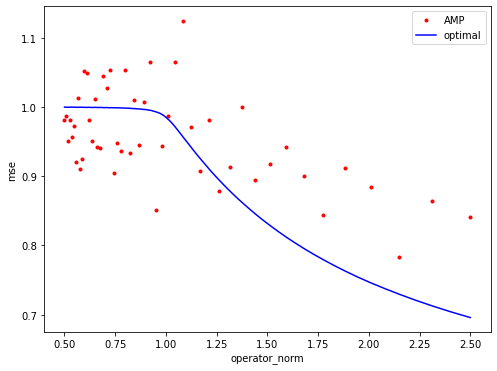

In [232]:
N = 100 #initializing dimension

start = 0.2 #from small noise
end = 1  #to big one
points = 50 #number of different levels of noise to visualize in the range

prior = 'gaussian'
x_axis = 'operator_norm'
y_axis = 'mse'

proportions = [0.5, 0.5] #proportions of blocks respectively, number of blocks can be arbitrary
sizes = [int(N * proportion) for proportion in proportions]
sizes[-1] += (N - sum(sizes)) #sum of sizes should be always equal to N

#Choosing the block noise matrix
#off_diag = 500
block_delta = np.array([[1, 200], [200, 20]]) 

delta_collection = create_block_matrix_collection(start, end, points, sizes, block_delta) 

to_visualize = [create_object('amp', 'red'),
           create_object('optimal', 'blue')]
visualize(to_visualize)